In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, k_from_Ic, solve_Ic, SBT_from_Ic, ms_layer_assignment
from scipy import stats
from ngl_tools import smt

import warnings
warnings.filterwarnings("ignore")

In [3]:
## setup cpt data 
cpt = setup_cpt('./USGS_CPT_data/')
## fill any missing water depths with the median
default_dGWT = np.nanmedian([cpt[bh]['Water depth'] for bh in cpt if not np.isnan(cpt[bh]['Water depth'])])
for bh in cpt:
    if np.isnan(cpt[bh]['Water depth']):
        cpt[bh]['Water depth'] = default_dGWT
cpt = soil_stress(cpt)
calc_SBT(cpt)

for _, data in cpt.items():
    data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
    qt_inv, fs_inv, _ = smt.cpt_inverse_filter(np.array(data['CPT_data']['q_c']), np.array(data['CPT_data']['d']), fs=data['CPT_data']['f_s'], sigmav=data['CPT_data']['sig_v'], sigmavp=data['CPT_data']['sig_prime_v'])
    Ic_inv, _, _ = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'])
    data['CPT_data']['I_c_inv'] = Ic_inv
    data['SBT_inv'],_ = SBT_from_Ic(Ic_inv)
    data['k_fromIc_inv'] = k_from_Ic(Ic_inv)
    data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])


In [4]:
## ok for bh ALC009, test out the cost function for a CP at 11m versus at 19 m
CP1 = 4
CP2 = 19
bh = 'ALC012'
x_data = 'SBT'#_inv'
# find the average SBT above the CP1 and CP2
mu1_0 = cpt[bh][x_data][cpt[bh]['CPT_data']['d'] < CP1].mean()
mu2_0 = cpt[bh][x_data][cpt[bh]['CPT_data']['d'] < CP2].mean()
# find the average SBT below the CP1 and CP2
mu1_1 = cpt[bh][x_data][cpt[bh]['CPT_data']['d'] >= CP1].mean()
mu2_1 = cpt[bh][x_data][cpt[bh]['CPT_data']['d'] >= CP2].mean()
# now, get the difference between the values and the means
delta1= cpt[bh][x_data] - mu1_0
delta2 = cpt[bh][x_data] - mu1_1
# and take the values from above CP1 as delta 1 and below as delta 2
delta1 = delta1[cpt[bh]['CPT_data']['d'] < CP1]
delta2 = delta2[cpt[bh]['CPT_data']['d'] >= CP1]
# and concatenate the two in np
error1 = np.concatenate((delta1, delta2))
# and repeat for CP2
delta0= cpt[bh][x_data] - mu2_0
delta2 = cpt[bh][x_data] - mu2_1
delta0 = delta0[cpt[bh]['CPT_data']['d'] < CP2]
delta2 = delta2[cpt[bh]['CPT_data']['d'] >= CP2]
error2 = np.concatenate((delta0, delta2))


Text(0.5, 1.0, 'Hydraulic Conductivity,\n K [m/s]')

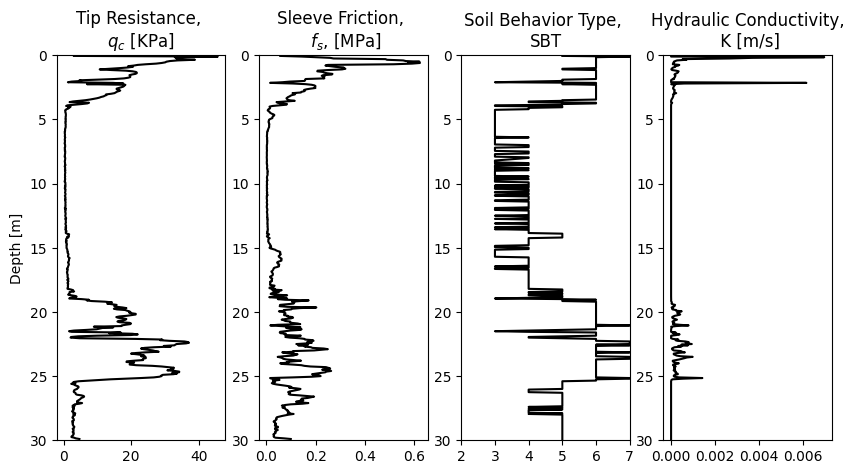

In [30]:
fig, axes = plt.subplots(1,4,figsize=(10,5))
ax = axes[0]
ax.plot(cpt[bh]['CPT_data']['q_c'], cpt[bh]['CPT_data']['d'],'k')
ax.set_ylim(30,0)
ax.set_ylabel('Depth [m]')
ax.set_title('Tip Resistance, \n$q_c$ [KPa]')

ax=axes[1]
ax.plot(cpt[bh]['CPT_data']['f_s'], cpt[bh]['CPT_data']['d'],'k')
ax.set_ylim(30,0)
ax.set_title('Sleeve Friction, \n $f_s$, [MPa]')

ax = axes[2]
ax.plot(cpt[bh]['SBT'], cpt[bh]['CPT_data']['d'],'k')
ax.set_ylim(30,0)
ax.set_xlim(2,7)
ax.set_xticks(np.arange(2,8,1))
ax.set_title('Soil Behavior Type, \nSBT')

ax = axes[3]
ax.plot(cpt[bh]['CPT_data']['k_fromIc'], cpt[bh]['CPT_data']['d'],'k')
ax.set_ylim(30,0)
ax.set_title('Hydraulic Conductivity,\n K [m/s]')

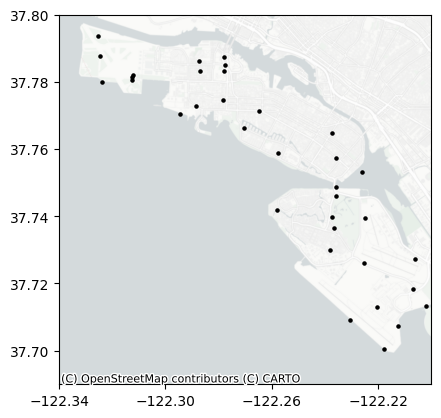

In [29]:
# make cpt a geodataframe from dict 
cpt_gdf = gpd.GeoDataFrame.from_dict(cpt, orient='index')
# plot with black points
cpt_gdf['geometry'] = gpd.points_from_xy(cpt_gdf['Lon'], cpt_gdf['Lat'], crs='EPSG:4326')
ax = cpt_gdf.plot(color='k',markersize=5)
# make a basemap using positron no labels
plt.xlim(-122.34,-122.2)
plt.xticks(np.arange(-122.34,-122.2,0.04))
plt.ylim(37.69, 37.8)
ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.CartoDB.PositronNoLabels, zorder=-1)
plt.show()

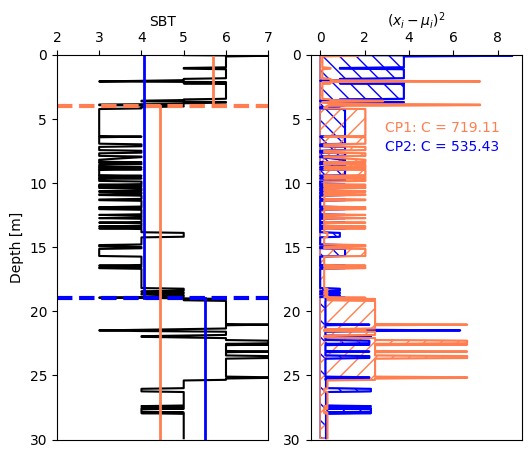

In [92]:
fig, axes = plt.subplots(1,2,figsize=(6,5))
ax = axes[0]
ax.plot(cpt[bh][x_data], cpt[bh]['CPT_data']['d'],'k')
# make a horizontal dashed line at the CP1 and CP2
ax.axhline(CP1, color='coral', linestyle='--', linewidth=3)
ax.axhline(CP2, color='b', linestyle='--', linewidth=3)
# plot the mu values as vertical lines
ax.plot([mu1_0,mu1_0], [0,CP1], color='coral', linestyle='-', linewidth=2)
ax.plot([mu1_1,mu1_1], [CP1,30], color='coral', linestyle='-', linewidth=2)
ax.plot([mu2_0,mu2_0], [0,CP2], color='b', linestyle='-', linewidth=2)
ax.plot([mu2_1,mu2_1], [CP2,30], color='b', linestyle='-', linewidth=2)
ax.set_ylim(30,0)
ax.set_xlim(2,7)
ax.set_xlabel('SBT')
ax.set_ylabel('Depth [m]')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax = axes[1]
## now plot the square error
ax.plot(error2**2, cpt[bh]['CPT_data']['d'], 'b')
ax.plot(error1**2, cpt[bh]['CPT_data']['d'], 'coral')
# create a hashing between the error**2 and the 0 line
ax.fill_betweenx(cpt[bh]['CPT_data']['d'], error2**2, 0, facecolor='none', hatch='\\\\', edgecolor='b')
ax.fill_betweenx(cpt[bh]['CPT_data']['d'], error1**2, 0, facecolor='none', hatch='//', edgecolor='coral')

ax.set_ylim(30,0)
# plot text in blue and coral that say CP1 and CP2 C = and then the sum of the error squared
ax.text(0.35, 0.8, f'CP1: C = {np.sum(error1**2):.2f}', transform=ax.transAxes, color='coral')
ax.text(0.35, 0.75, f'CP2: C = {np.sum(error2**2):.2f}', transform=ax.transAxes, color='b')
ax.set_xlabel('$(x_i - \mu_i)^2$')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.savefig('figures/CP_cost_function.png', dpi=1000, bbox_inches='tight')
plt.savefig('figures/CP_cost_function.pdf', dpi=1000, bbox_inches='tight')


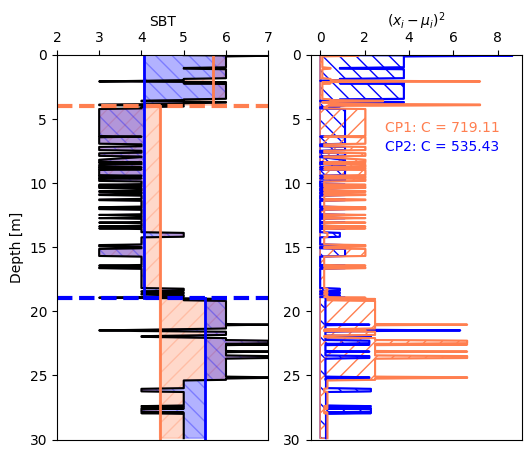

In [90]:
fig, axes = plt.subplots(1,2,figsize=(6,5))
ax = axes[0]
ax.plot(cpt[bh][x_data], cpt[bh]['CPT_data']['d'],'k')
# make a horizontal dashed line at the CP1 and CP2
ax.axhline(CP1, color='coral', linestyle='--', linewidth=3)
ax.axhline(CP2, color='b', linestyle='--', linewidth=3)
# plot the mu values as vertical lines
ax.plot([mu1_0,mu1_0], [0,CP1], color='coral', linestyle='-', linewidth=2)
ax.plot([mu1_1,mu1_1], [CP1,30], color='coral', linestyle='-', linewidth=2)
ax.plot([mu2_0,mu2_0], [0,CP2], color='b', linestyle='-', linewidth=2)
ax.plot([mu2_1,mu2_1], [CP2,30], color='b', linestyle='-', linewidth=2)
# shade between the mus and the SBT values above and below each CP
ax.fill_betweenx(cpt[bh]['CPT_data']['d'][cpt[bh]['CPT_data']['d'] < CP1], mu1_0, cpt[bh][x_data][cpt[bh]['CPT_data']['d'] < CP1], 
                 facecolor='coral', hatch='//', alpha=0.3, edgecolor='coral')
ax.fill_betweenx(cpt[bh]['CPT_data']['d'][cpt[bh]['CPT_data']['d'] >= CP1], mu1_1, cpt[bh][x_data][cpt[bh]['CPT_data']['d'] >= CP1], 
                 facecolor='coral', hatch='//', alpha=0.3,edgecolor='coral')
ax.fill_betweenx(cpt[bh]['CPT_data']['d'][cpt[bh]['CPT_data']['d'] < CP2], mu2_0, cpt[bh][x_data][cpt[bh]['CPT_data']['d'] < CP2], 
                 facecolor='b',  hatch='\\\\',alpha=0.3,edgecolor='b')
ax.fill_betweenx(cpt[bh]['CPT_data']['d'][cpt[bh]['CPT_data']['d'] >= CP2], mu2_1, cpt[bh][x_data][cpt[bh]['CPT_data']['d'] >= CP2], 
                 facecolor='b', hatch='\\\\', alpha=0.3, edgecolor='b')


ax.set_ylim(30,0)
ax.set_xlim(2,7)
ax.set_xlabel('SBT')
ax.set_ylabel('Depth [m]')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax = axes[1]
## now plot the square error
ax.plot(error2**2, cpt[bh]['CPT_data']['d'], 'b')
ax.plot(error1**2, cpt[bh]['CPT_data']['d'], 'coral')
# create a hashing between the error**2 and the 0 line
ax.fill_betweenx(cpt[bh]['CPT_data']['d'], error2**2, 0, facecolor='none', hatch='\\\\', edgecolor='b')
ax.fill_betweenx(cpt[bh]['CPT_data']['d'], error1**2, 0, facecolor='none', hatch='//', edgecolor='coral')

ax.set_ylim(30,0)
# plot text in blue and coral that say CP1 and CP2 C = and then the sum of the error squared
ax.text(0.35, 0.8, f'CP1: C = {np.sum(error1**2):.2f}', transform=ax.transAxes, color='coral')
ax.text(0.35, 0.75, f'CP2: C = {np.sum(error2**2):.2f}', transform=ax.transAxes, color='b')
ax.set_xlabel('$(x_i - \mu_i)^2$')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.savefig('figures/CP_cost_function_shaded.png', dpi=1000, bbox_inches='tight')
plt.savefig('figures/CP_cost_function_shaded.pdf', dpi=1000, bbox_inches='tight')


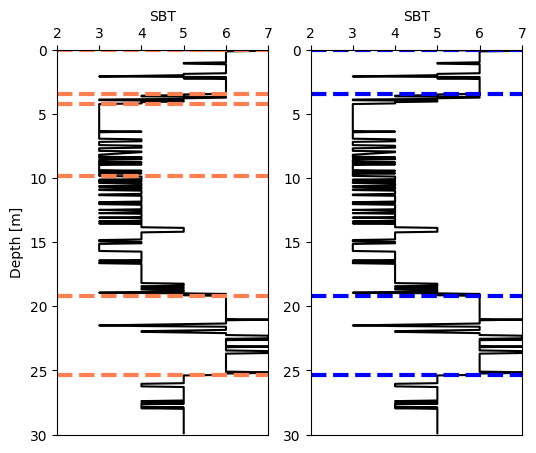

In [94]:
# now make a plot that uses the agglomerative clustering and then has the two plots one with t_ref = 3 and the other with t_ref = 8
# run the same comparison using smt and t_ref of 3,6,9

# assess what is happening at individual boreholes with a plot
# METHOD FOR THIS TEST IS CP with MS
preprocess = False
layers_dict = {}


df = cpt[bh]['CPT_data']
depth = cpt[bh]['CPT_data']['d'].values

# make a 1x3 subfigure to fill in the loop
fig,axes = plt.subplots(1,2,figsize=(6,5))
trefs=[3,8]
cols = ['coral','b']
for i, (ax,t_ref) in enumerate(zip(axes.flatten(),trefs)):
    if preprocess:
        SBT = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)
    ztop, zbot, _, _ = smt.cpt_layering(np.array(SBT), np.array(logKh), depth, tref=t_ref, Nmax=None)
    SBTs = []
    for indx in range(len(ztop)):
        start_idx = np.where(depth >= ztop[indx])[0][0]
        end_idx = np.where(depth >= zbot[indx])[0][0]
        SBTs.append(stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0])
    
    ax.plot(SBT, depth, 'k')
    for z in ztop:
        ax.axhline(z, color=cols[i], linestyle='--', linewidth=3)
    ax.set_ylim(30,0)
    ax.set_xlim(2,7)
    ax.set_xlabel('SBT')
    if i == 0:
        ax.set_ylabel('Depth [m]')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

plt.savefig('./figures/cluster_eg.png',format='png',dpi=1000,bbox_inches='tight')
plt.savefig('./figures/cluster_eg.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
